# Satellite Solver

In [35]:
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import mqt.ddsim

In [36]:
MinimumEigenOptimizer(VQE(quantum_instance=mqt.ddsim.DDSIMProvider().get_backend("qasm_simulator"))).solve(qubo)

<MinimumEigenOptimizationResult: fval=-3.0, requests_0=0.0, requests_1=1.0, requests_2=0.0, requests_3=1.0, requests_4=0.0, status=SUCCESS>

# Generate Plots

In [42]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

size = 14
legendsize = 12

In [43]:
df = pd.read_csv('res_satellite_solver.csv', sep=',')
df

,num_qubits,calculation_time_qaoa,calculation_time_wqaoa,calculation_time_vqe,success_rate_qaoa,success_rate_wqaoa,success_rate_vqe
0,3,0.368371,0.263994,0.346291,1.000000,1.000000,1.000000
1,4,0.282966,0.302263,0.363376,1.000000,1.000000,1.000000
2,5,0.492754,0.479723,0.458954,1.000000,0.916667,0.916667
3,6,0.375893,0.471194,0.713291,1.000000,1.000000,1.000000
4,7,1.128316,1.207596,1.182640,1.000000,0.888889,0.888889
5,8,1.623866,1.908310,1.743372,0.944444,1.000000,1.000000
6,9,1.800673,1.936991,2.415794,0.700000,0.800000,1.000000


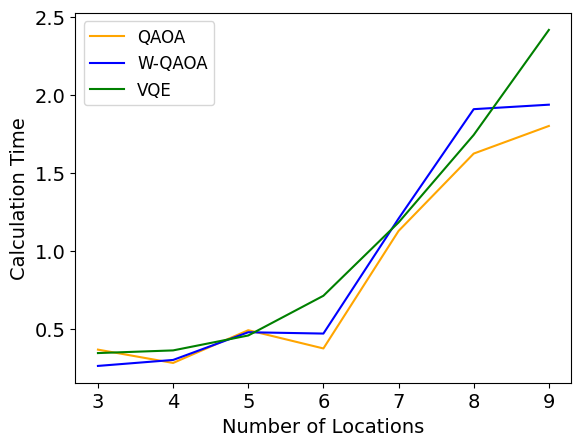

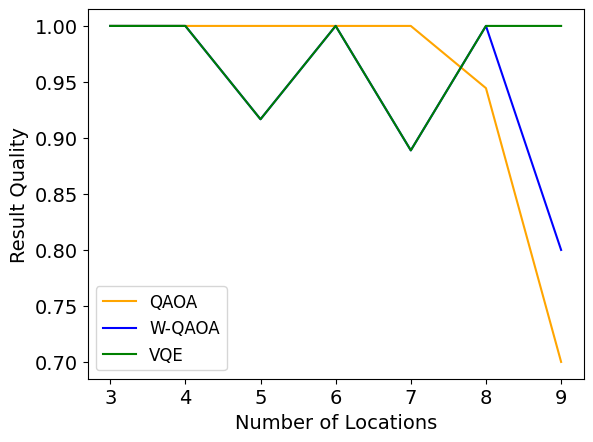

In [62]:
ax1 = df.plot(x='num_qubits', y='calculation_time_qaoa', color='orange', label="QAOA")   
ax1.tick_params(which='both', labelsize=size)
ax2 = df.plot( x='num_qubits', y='calculation_time_wqaoa', color='blue', ax=ax1, label="W-QAOA") 
ax3 = df.plot( x='num_qubits', y='calculation_time_vqe', color='green', ax=ax1, label="VQE") 

plt.xlabel("Number of Locations", size=size)
plt.ylabel("Calculation Time", size=size)
plt.legend(fontsize=legendsize)
plt.savefig('sat_solver_time.pdf')
plt.show()

ax1 = df.plot(x='num_qubits', y='success_rate_qaoa', color='orange', label="QAOA")   
ax1.tick_params(which='both', labelsize=size)
ax2 = df.plot( x='num_qubits', y='success_rate_wqaoa', color='blue', ax=ax1, label="W-QAOA") 
ax3 = df.plot( x='num_qubits', y='success_rate_vqe', color='green', ax=ax1, label="VQE") 

plt.xlabel("Number of Locations", size=size)
plt.ylabel("Result Quality", size=size)
plt.legend(fontsize=legendsize)
plt.savefig('sat_solver_quality.pdf')
plt.show()

## Imports

In [3]:
from mqt import ddsim
import numpy as np

from mqt.problemsolver.satellitesolver import utils
from mqt.problemsolver.satellitesolver.utils import  QAOA, W_QAOA

from qiskit import Aer, execute
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters.quadratic_program_to_qubo import (
    QuadraticProgramToQubo,
)
from qiskit.algorithms.optimizers import L_BFGS_B, ADAM, SPSA

import matplotlib.pyplot as plt

import warnings
import time

## Create arbitrary Satellite Problem Instance

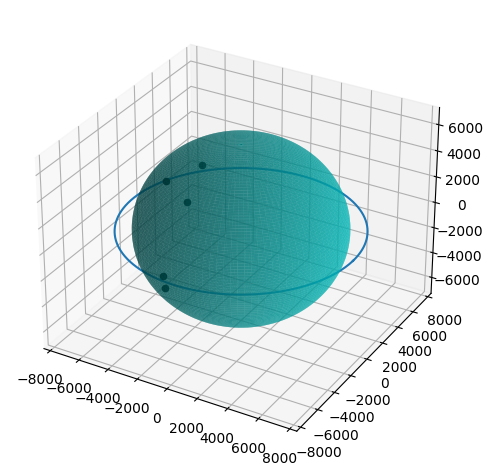

In [4]:
num_requests = 5
ac_reqs = utils.init_random_acquisition_requests(num_requests)
utils.plot_acqisition_requests(ac_reqs)

## Create Docplex Model and Convert it to QUBO Formulation

In [65]:
penalty = None
mdl = utils.create_satellite_doxplex(ac_reqs)
print(qubo.prettyprint())
print(qubo.to_ising())

Problem name: satellite model

Minimize
  8*requests_0*requests_1 + 8*requests_0*requests_3 + 8*requests_0*requests_4
  + 8*requests_1*requests_2 + 8*requests_3*requests_4 - requests_0 - requests_1
  - requests_2 - 2*requests_3 - 2*requests_4

Subject to
  No constraints

  Binary variables (5)
    requests_0 requests_1 requests_2 requests_3 requests_4

(PauliSumOp(SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIZZ', 'IIZZI', 'IZIIZ', 'ZIIIZ', 'ZZIII'],
              coeffs=[-5.5+0.j, -3.5+0.j, -1.5+0.j, -3. +0.j, -3. +0.j,  2. +0.j,  2. +0.j,
  2. +0.j,  2. +0.j,  2. +0.j]), coeff=1.0), 6.5)


# Utilize Qiskit Runtime

In [ ]:
# Code Structure is taken from https://qiskit.org/ecosystem/optimization/tutorials/12_qaoa_runtime.html
from qiskit import IBMQ
from mqt.problemsolver.satellitesolver import utils
import numpy as np

from qiskit.tools import job_monitor
from qiskit.algorithms.optimizers import SPSA

IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)
print(f"Program name: {qaoa_program.name}, Program id: {qaoa_program.program_id}")
print(qaoa_program.parameters())


# SPSA helps deal with noisy environments.
optimizer = SPSA(maxiter=100)

reps = 3
initial_point = np.random.random(2 * reps)

options = {"backend_name": "ibmq_quito"}

ac_reqs = utils.init_random_acquisition_requests(5)
mdl = utils.create_satellite_doxplex(ac_reqs)
converter, qubo = utils.convert_docplex_to_qubo(mdl)
op = qubo.to_ising()[0]

runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
}

job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

print(f"Job id: {job.job_id()}")
print(f"Job status: {job.status()}")

In [ ]:
job.status()

In [ ]:
result = job.result()
most_likely_eigenstate_qaoa = utils.sample_most_likely(result.get("eigenstate"))
print(utils.check_solution(ac_reqs, most_likely_eigenstate_qaoa))

# Retrieve Old Job

In [ ]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
job = provider.runtime.job('cgv91esueeovm2ug0lig')
result = job.result()
most_likely_eigenstate_qaoa = utils.sample_most_likely(result.get("eigenstate"))
most_likely_eigenstate_qaoa